                                             Workshop 3: Pete Hellyer - Edited from  Dragos Gruia and Valentina Giunchiglia

# Introduction to structural and functional MRI analysis in Python

The aim of the workshop of today is to introduce you to the group level functional MRI analysis using Python.

The data for the lecture of today are saved in the format of a `nii` file. nii is  special file format that is often used in neuroimaging to store functional and stuctural MRI data. The first thing you need to do is to import the module, together with other modules you will need in the workshop.

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import pickle
import seaborn as sb
import pandas as pd
%matplotlib inline
import numpy as np
import os
import warnings

warnings.filterwarnings('ignore')

sb.set_theme("talk")
sb.set_style("whitegrid")

## Analysis of functional network abnormalities in clinical populations

At this point of the workshop, you should have a good overview on fMRI and sMRI data. Until now, we analysed individual images. We will now try to infer some results at the population level. The analysis of the images of each individual subject is called **first level analysis**, and it involves the whole brain regression analysis we studied in the first part of the workshop. Once you completed the first level analysis, you can move on to the **second level analysis** which is a group analysis.

In this part of the workshop, we will run a second level analysis and, in more detail, we will analyse data from a study of Parkinson's disease patients. In addition to the primary motor symptoms, Parkinson’s patients have a higher likelihood of developing dementia. A number of genetic factors have been linked to this risk, one of them being MAPT genotype, which relates to the microtubule assembly protein Tau. To test whether MAPT has a relationship with memory impairments in PD, we will examine activation levels in the medial temporal lobes, which are central to memory function, while the patients and controls perform a memory encoding task. The original analysis was published [here](https://www.sciencedirect.com/science/article/pii/S0197458014007982).

The participants were presented with a series of abstract art pictures whilst in the MRI scanner. They were asked to commit them to memory. When they left the scanner, they were tested on their ability to recognise the pictures that they had been presented with. Also in this case, the task had a block design (fixation vs task stimulus).

![image_parkinson.jpg](attachment:4e745fcd-6e90-4aa3-8059-25ae35a224ca.jpg)

By using as regressors the presentation of stimuli that are succesfully and not succesfully recalled, it is possible to obtain measures of brain activation during recalled and not recalled stimuli. It is then possible to compare the brain activation between recalled vs not recalled to evaluate what are the differences. More details on how this is concretely achieved will be provided later on in the year, in Module 6, if you decide to go for the Computational stream. The important information is that a difference in the activation in the **medial temporal lobes** is commonly observed, and this is why we will focus the analysis on this region of interest and we will study cross-group differences in this ROI.

The H2 allele is rarer than the H1 allele; therefore, few individuals are homozygous for H2. However, it is believed that one copy of the H2 allele helps counter the dementia risk. Therefore, our hypothesis is that when committing pictures to memory, the H2 carriers will show more activation in medial temporal lobe structures that support memory functions than the H1 homozygotes.

Furthermore, we hypothesise that there could be a more pronounced effect of MAPT in the patients than the controls.

To test these predicitons, fMRI data were collected from 40 controls and 37 PD patients while they performed the memory task. 21 of the controls were homozygous for the H1 MAPT genotype and 19 had one or more H2 alleles. 19 patients were H1 homozygotes and the remaining 18 had one or more H2 alleles.

Activation during successful vs unsuccessful memory encoding was calculated for each voxel in the brain at the individual subject level using a generalised linear regression model (more information on how to do this will be provided in M6). The resultant whole brain maps depicting the final beta coefficients obtained after comparing the recalled vs not recalled stimuli are in the folder *02_MAPT_PD* inside the *Data* directory. Inside the folder you will find 4 separate directories:
1. *CONTROL_H1*: whole brain beta coefficients maps for control patients with the H1 allele
2. *CONTROL_H2*: whole brain beta coefficients maps for control patients with the H2 allele
3. *PD_H1*: whole brain beta coefficients maps for Parkinson's patients with the H1 allele
4. *PD_H2*: whole brain beta coefficients maps for Parkinson's patients with the H2 allele

In addition you will have two additional images that correspond to a standard MNI brain template (*MNI152_T1_1mm*) and a mask for the medial temporal lobes (*Hippocampus_Mask*). The former corresponds to a brain image obtained by averaging out brains from multiple healthy controls. It is used as a standard representation of how a healthy brain should look like. Instead, the latter is a mask that specifies where in the brain the medial temporal lobe is located. It is similar to the brain mask we used at the beginning of the workshop to identify which parts of the image belong to the background and which to the brain, but this time the part that is highlighted is only the medial temporal lobe.

All the brain images are saved in `nifti` format, which is a typical file format for neuroimaging. In order to work with `nifti` images in python, it is necessary to download and import a new module, called `nibabel`.


In [2]:
pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.7 kB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import nibabel as nib

Let's start by importing the standard template and the mask, and let's check them out. In this way, it will be easier to understand what they are. We convert the images to array because in Python it is easier to work with arrays comapred to images.

In [5]:
template = nib.load("Data/02_MAPT_PD/MNI152_T1_1mm.nii")
mask = nib.load("Data/02_MAPT_PD/Hippocampus_Mask.nii")

template_arr = np.array(template.dataobj)
mask_arr = np.array(mask.dataobj)

mask_arr.shape, template_arr.shape

((79, 95, 68), (79, 95, 68))

Text(0.5, 1.0, 'Brain template')

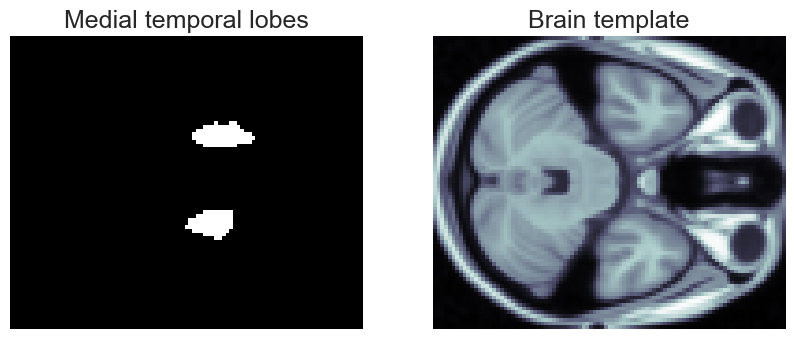

In [6]:
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.imshow(mask_arr[:, :, 9], cmap = "bone")
plt.axis("off")
plt.title("Medial temporal lobes")
plt.subplot(122)
plt.imshow(template_arr[:, :, 9], cmap = "bone")
plt.axis("off")
plt.title("Brain template")

A better way to visualize where the medial temporal love are located is to overlay the mask on top of the template. To overlay it, we can just set as 0 all the regions in the template image where the mask has a value bigger than 0 (e.g. the medial temporal lobes).

Text(0.5, 1.0, 'Coronal Plane')

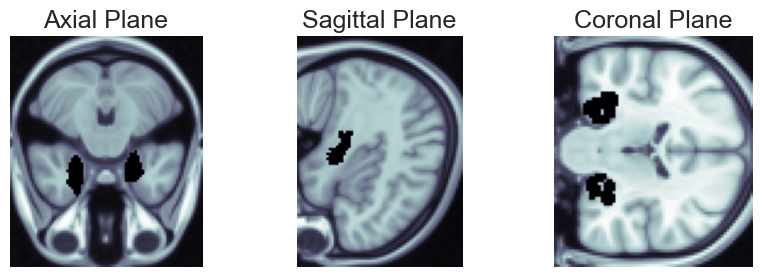

In [7]:
template_arr[mask_arr>0] = 0


plt.figure(figsize = (10, 3))
plt.subplot(131)
plt.imshow(template_arr[:, :, 9].T, cmap = "bone")
plt.axis("off")
plt.title("Axial Plane")
plt.subplot(132)
plt.imshow(template_arr[20, :, :], cmap = "bone")
plt.axis("off")
plt.title("Sagittal Plane")
plt.subplot(133)
plt.imshow(template_arr[:, 45, :], cmap = "bone")
plt.axis("off")
plt.title("Coronal Plane")

Now it's easier to visualize the medial temporal lobes along the three planes. Try to change the values in the x, y and z coordinates, you will see that the black shaded area will change in size and shape.

Now we want to import all the data for the different patients' and controls' groups. We will start by reading through all the *CONTROL_H1* files and import the beta weights images as array. In Python, there is a really nice and easy to use function called `listdir` (within the `os` module, which is already installed once you download Python) that can extract all the file names within a specific directory in a list format. In this way, it is easy to loop over the list of file names and import all the images at once.

In [8]:
path_directory = "Data/02_MAPT_PD/CONTROL_H1//"
control_h1_dir = os.listdir(path_directory)

control_h1_all = []
for file in control_h1_dir:
    loaded_img = nib.load(path_directory+file)
    imgfile = np.array(loaded_img.dataobj)
    control_h1_all.append(imgfile)

len(control_h1_all), control_h1_all[0].shape

(21, (79, 95, 68))

We now created a list where each element of the list is a brain activation map of a subject. Since we have 21 H1 controls, the list has 21 elements of shape (79, 95, 68). However, in Python, it is generally easier to work with arrays rather than list and this is why we will convert the list to an array.

In [9]:
control_h1_all = np.array(control_h1_all)
control_h1_all.shape

(21, 79, 95, 68)

As you can see, *control_h1_all* is now a 4D array of shape (21, 79, 95, 68). The first dimension of the array corresponds to the different subjects, instead the remaining dimensions are the normal dimensions of a brain image. This array is easier to work with because we can simply access the brain activation maps of each individual subject by filtering the first dimension of the array. Let's look at one example for the first subject at index 0 in dimension 1.

(-0.5, 94.5, 78.5, -0.5)

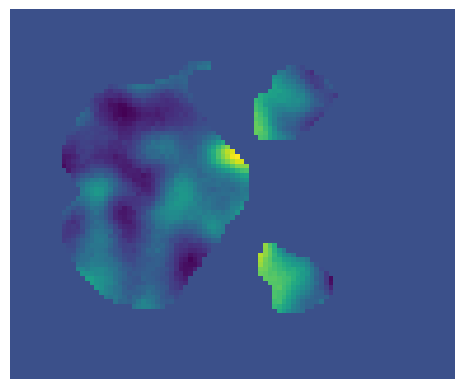

In [10]:
plt.imshow(control_h1_all[0, :, :, 9], cmap = "viridis")
plt.axis("off")

Great! Now that we have the brain activation maps for all subjects in one place, we can start doing some analysis. One of our main aims is to study the difference in activation within the medial temporal lobes across the different groups (Control H1, Control H2, Parkinson's H1 and Parkinson's H2). To be able to make that comparison, we need to calculate what is the mean activation across all subjects within each group in the ROI.

To do this, we need to complete a few steps:
1. Calculate the number of voxels that belong to the medial temporal lobes
2. Sum the beta coefficients values whithin the medial temporal lobes region
3. Calculate the average value by dividing the obtained sum for the number of voxels

In [11]:
nvoxelsinmask = np.nansum(mask_arr)
nvoxelsinmask

3988.0

By doing the `nansum`, we calculate the sum of the voxels across all dimensions. Now we can loop over all the subjects, extract each subject using the first dimension of the 4D array, multiply the brain mask for the array mask (since the mask has value 1 in the ROI and 0 in the other regions, we can filter the beta coefficients for the ROI), and obtain an average measure.

In [12]:
C_H1 = []

for n_subj in range(control_h1_all.shape[0]):

    # Extract each subject by using the first dimension of the array
    currentsubject = control_h1_all[n_subj,:,:, :]
    currentsubject = currentsubject * mask_arr
    mean_beta = np.nansum(currentsubject) /nvoxelsinmask
    C_H1.append(mean_beta)
print(C_H1)

[0.36272636, 0.08698163, 0.064414784, 0.5144385, 0.1459888, -0.3301602, 0.02844563, -0.42138183, -0.31603032, -1.0293784, -0.14496599, 0.058579784, 0.09201167, -0.2514752, 0.3129767, 0.037248563, 0.123540126, -0.10064192, -0.013825955, -0.4631708, -0.18568432]


-------
### Code here

We have now calculated average brain activation in the ROI for the *CONTROL_H1* group. Repeat the same steps of the analysis for the *CONTROL_H2*, *PD_H1*, and *PD_H2* group. Save the results in three lists called respectively C_H2, P_H1, and P_H2. Since the code is quite repetitive, you could try to extract it in a function to avoid having to copy and paste the same thing multiple times.


In [14]:
# Ok, great, it is repetitive, so let's create a function to avoid having to copy and paste loads.

# define what we call our function and what we're going to give it - in this case, we'll tell the function which folder each of our subject maps are in
# (n.b. explore the data and have a look!)

# recall the functions section of the intro lectures to understand what is going on here; functions start with a definition and end with a return

# so, lets define our function

def extract_subjects(path_directory):
    # and similar t what we did for H1, we will select our directory
    subject_dir = os.listdir(path_directory)
    
    # and adapt the code we used to load the images above to load the specified images
    subject_all = []
    for file in subject_dir:
        loaded_img = nib.load(path_directory+file)
        imgfile = np.array(loaded_img.dataobj)
        subject_all.append(imgfile)

    # and turn it into an array
    subject_all = np.array(subject_all)
    
    # Now adapt the code we used to extract values from the ROI previously to this data

    #firstly, load the mask
    mask = nib.load("Data/02_MAPT_PD/Hippocampus_Mask.nii")

    template_arr = np.array(template.dataobj)
    mask_arr = np.array(mask.dataobj)
    
    # then extract the means
    data = []

    for n_subj in range(subject_all.shape[0]):
    
        # Extract each subject by using the first dimension of the array
        currentsubject = subject_all[n_subj,:,:, :]
        currentsubject = currentsubject * mask_arr
        mean_beta = np.nansum(currentsubject) /nvoxelsinmask
        data.append(mean_beta)

    # functions usually end by returnng something - we want data!
    return data


# great! now lets run our function to get the data for all 4 groups

C_H1 = extract_subjects("Data/02_MAPT_PD/CONTROL_H1//")
C_H2 = extract_subjects("Data/02_MAPT_PD/CONTROL_H2//")
P_H1 = extract_subjects("Data/02_MAPT_PD/PD_H1//")
P_H2 = extract_subjects("Data/02_MAPT_PD/PD_H2//")



In [16]:
#lets just have a quick look at some of those
C_H1

[-0.32798862,
 0.27145925,
 -0.20027131,
 0.025907245,
 0.45154226,
 0.21483025,
 0.19343494,
 0.62244123,
 0.6550979,
 -0.06962775,
 0.28052646,
 0.4450525,
 0.008609308,
 -0.07411311,
 0.42574945,
 0.31802282,
 0.45250198,
 0.08441498,
 2.1569705]

In [17]:
C_H2

[-0.32798862,
 0.27145925,
 -0.20027131,
 0.025907245,
 0.45154226,
 0.21483025,
 0.19343494,
 0.62244123,
 0.6550979,
 -0.06962775,
 0.28052646,
 0.4450525,
 0.008609308,
 -0.07411311,
 0.42574945,
 0.31802282,
 0.45250198,
 0.08441498,
 2.1569705]

---------

In [19]:
P_H1

[-0.38269717,
 0.021976305,
 0.039802983,
 0.054847162,
 -0.2942376,
 0.2602819,
 0.10630527,
 -0.19080195,
 -0.08196546,
 -0.09637376,
 -0.057485465,
 -0.004200795,
 -0.9952139,
 -0.14766349,
 -0.683858,
 -0.0846571,
 -0.17919238,
 0.024464907,
 0.08521706]

In [20]:
P_H2

[0.46716297,
 1.1776648,
 -0.18425019,
 0.033355568,
 -0.025846895,
 1.0109984,
 0.375036,
 0.2313377,
 0.07855012,
 0.49093574,
 0.008209557,
 0.6840206,
 0.062270034,
 0.3060755,
 0.15202016,
 -0.02700165,
 -0.043159988,
 0.07783476]

Once you have completed the above exercise, you can move on with the next steps of the workshop. Let's look at the distributions of the obtained data.

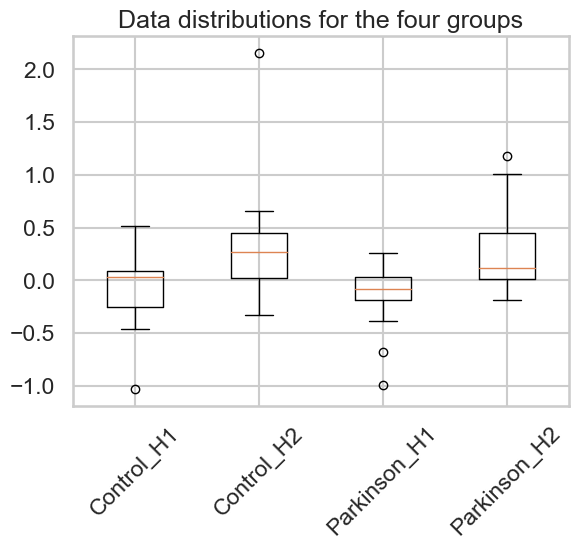

In [21]:
_ = plt.boxplot([C_H1, C_H2, P_H1, P_H2], labels = ["Control_H1", "Control_H2", "Parkinson_H1", "Parkinson_H2"])
_ = plt.title('Data distributions for the four groups')
_ = plt.xticks(rotation=45)

Simply by looking at the plot, you can notice two things: 1) the H2 carriers may be activating their medial temporal lobes more strongly than the H1 homozygotes, 2) The data have some outliers. To address the second point, we can winsorize the data as we learnt in the previous workshops.

-------
### Code here

Winsorize the data using the `winsorize` function from `scipy.stats.mstats`, and winsorise the data above the 95% and below the 5% percentile. Once you did that, plot the boxplot again and check whether the winsorization was successfull. Call the winsorized values *C_H1_W*, *C_H2_W*, *P_H1_W*, and *P_H2_W*. Do you still see outliers in the boxplot? If yes, why do you think it is the case? Are those really outliers?

In [43]:
# Windsorisation removes outliers from the dataset- reducing potential noisy data from our analysis

# lets use the scipy.stats.mstats command
# first we need to tell python we want to use it by importing it.

from scipy.stats.mstats import winsorize

# this command doesnt like taking lists, so we need to tell it that it is a list of numbers using np.array, we also need to tell
# tell the command how many % we want to trim away from each end of our data

C_H1_W = winsorize(np.array(C_H1), limits=[0.05, 0.05])
# we'll repeat that for each group
C_H2_W = winsorize(np.array(C_H2),limits=[0.05, 0.05])
P_H1_W = winsorize(np.array(P_H1),limits=[0.05, 0.05])
P_H2_W = winsorize(np.array(P_H2),limits=[0.05, 0.05])

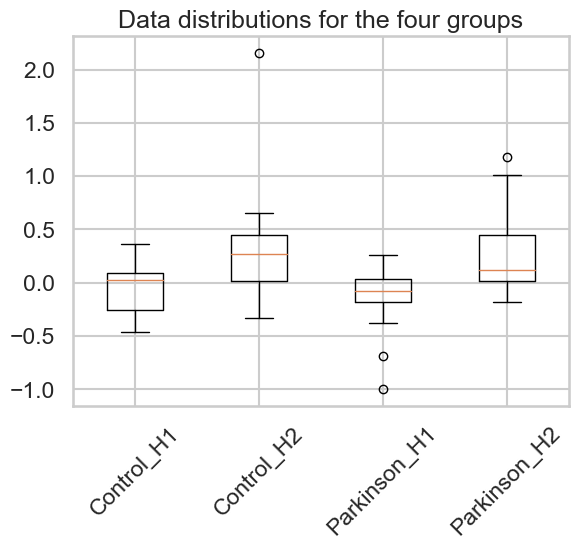

In [44]:
# and then lets boxplot them using the code above
_ = plt.boxplot([C_H1_W, C_H2_W, P_H1_W, P_H2_W], labels = ["Control_H1", "Control_H2", "Parkinson_H1", "Parkinson_H2"])
_ = plt.title('Data distributions for the four groups')
_ = plt.xticks(rotation=45)

---------

Now that we cleaned the data, let's check whether they are normally distributed before running any type of analysis.

In [45]:
winsorized_data = [C_H1_W, C_H2_W, P_H1_W, P_H2_W]

for i, data in enumerate(winsorized_data):
    shapiro_pvalue = shapiro(data).pvalue
    if shapiro_pvalue < 0.01:
        print("Distribution of group", i, "is significantly different from a normal distribution")

Distribution of group 1 is significantly different from a normal distribution
Distribution of group 2 is significantly different from a normal distribution


As you can see, at least 2 groups are not normally distributed. This means that it is impossible to use **parametric** tests, which have as requirement that the data must be normally distributed. An alternative to parametric tests is **non parametric** tests, such as **permutation** analysis. Permutation works as follows. Let's say we have two groups, such as C_H1 and C_H2. We first calculate the observed difference between the mean activations in the two groups. We then randomly interchange the data between the two groups N times, and measure the mean difference between the permuted groups each time. From this, we can infer what the probability is of observing the difference in the non-permuted data due to chance alone, that is, without making any assumptions regarding the distribution of the observed data. If that probability is low, then we reject the null hypothesis that the groups are the same.

A funny, and easy to understand visualization of permutation testing can be found at this [link](https://www.jwilber.me/permutationtest/).

Let's define a function for permutation testing, that calculated the p-value and plots the random distribution together with the actual observed mean difference.

In [50]:
import random

def permutation(g1, g2, N):
    dists = []
    diff = np.abs(np.nanmean(g1) - np.nanmean(g2)) # Calculate the difference between means
    n_g1 = len(g1) # Calculate the number of observations in group 1
    n_g2 = len(g2)
    for perm in range(N):
        merged_groups = list(g1) + list(g2) # Add group 1 and group 2 together in a long vector (or column)
        random.shuffle(merged_groups) # Randomly shuffle the values in the column
        g1_r = merged_groups[0:n_g1] # Split back the values from the long vector into the two groups we had initially. The main difference now is that their values are shuffled.
        g2_r = merged_groups[n_g1:n_g1+n_g2]
        dist = np.abs(np.nanmean(g1_r) - np.nanmean(g2_r)) # Calculate the difference in means between these two shuffled groups
        dists.append(dist) #Add the results of the difference to a variable. This process gets repeated many times (i.e. N times) until you create a distribution of these shuffled mean differences.
    p_value = np.nansum(diff < dists) / N # Compare the un-shuffled mean difference with the distribution of shuffled mean differences to estimate whether there is a mean difference between the unshuffled groups
    plt.hist(dists) #Plot these differences
    plt.axvline(x = diff, c = "red")
    return p_value


One of our predictions is that the MAPT genotype affects medial temporal lobe function in controls. We can address this using our function by determining the probability of observing a difference between the H2 and H1 groups of the scale that was actually observed but when the data are randomly shuffled between the two groups.

0.0025

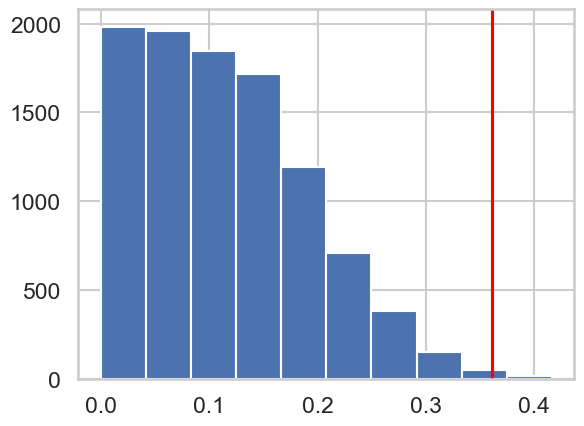

In [53]:
permutation(C_H1_W, C_H2_W, 10000)

Here the answer is significant at the P<0.001 one-tailed threshold in the direction predicted by our hypothesis. Try to rerun the function. Do the results change? Why do you think that's the case?

Repeat the same analysis, but this time compare the Parkinsons' patients.

Nevertheless, we are not only interested in checking whether the MAPT genotype has an effect, but we would like to study whether the effect is different for healthy controls or Parkinson's patients, which means checking whether there is an interaction effect between the MAPT genotype and the disease status. Thus, we want to run a regression analysis, with an interaction effect (similarly to what we did on Day 3) and then apply a permutation analysis to this, to estimate the p-values of this regression. This approach is also known as a 2x2 permutation analysis.

The idea relates to the definition of a p-value: what's the chance to observe this effect (the coefficient of my model) by random chance alone?
We will calculate this probability as the proportion of times our coefficient is **smaller** than the coefficient you would get randomly.
If we make enough experiments, that proportion will tend towards the true probability.

To get a "random coefficient" means to build a regression model (with an interaction effect) on random data, and that is precisely what we will do:

1. We first perform a linear regression to get the observed coefficients
2. Then we build the null distribution by performing 1,000 random regressions
3. Each random regression will consists of building a regression model but randomly permuting the response variable `Y``
4. The p-value for each coefficient will be the proportion of cases in which the observed coefficient is smaller than a random one.
5. Compute the 2-tailed p-values

In [54]:
def perm2x2(y, x1, x2, n):
    """
    Permutation function for two conditions with unpaired samples
    we calculate the probability of observing a cross group difference or
    interaction of the observed scale by chance given the data.
    y is observed data
    x1 is the first factor
    x2 is the second factor
    n is the number of random permutations
    Returns:
        pf1n pf2, pint are the positions of the observed data within the
        permutation null distribution
    """
    #1. Build real model and get observed coefficients
    real_df = pd.DataFrame({"y": y, "x1": x1, "x2": x2})
    real_model = sm.OLS.from_formula(
        "y ~ 1 + x1 + x2 + x1:x2",
        data = real_df
    ).fit()
    real_coefs = real_model.params

    #2. Build null distribution by getting the coefficients of random models
    random_df = real_df.copy()
    random_coefs = np.zeros((n, 4))
    for i in range(n):
        np.random.shuffle(random_df["y"].values)
        random_model = sm.OLS.from_formula("y ~ 1 + x1 + x2 + x1:x2", data = random_df).fit()
        random_coefs[i, :] = random_model.params

    #3. Calculate p-value as proportion of random coefficients smaller than ours
    # Remember that real_coefs[0] is intercept
    p_factor_1    = (real_coefs[1] < random_coefs[:, 1]).sum() / n
    p_factor_2    = (real_coefs[2] < random_coefs[:, 2]).sum() / n
    p_interaction = (real_coefs[3] < random_coefs[:, 3]).sum() / n

    #4. We're interested in coefficients either larger or smaller than ours,
    # so we convert the single-tail p-values to 2-tail p-values
    p_factor_1    = min([p_factor_1, 1-p_factor_1]) * 2
    p_factor_2    = min([p_factor_2, 1-p_factor_2]) * 2
    p_interaction = min([p_interaction, 1-p_interaction]) * 2

    return p_factor_1, p_factor_2, p_interaction

Now that we finally defined the function, let's try to run the analysis. What we want to do is to predict the actual mean brain activation values (Y) using as regressors the MAPT genotype (X1), the disease status (X2) and their interaction effect (X3). To do that, we need to concatenate all the beta activation values together, and then define the X1 and X2 regresssors. To define the latter, we will simply assign a value of 1 to one condition (e.g. H1) and -1 to the other condition (e.g. H2).

In [61]:
import statsmodels.api as sm
merged_data = np.array(list(C_H1_W) + list(C_H2_W) + list(P_H1_W) + list(P_H2_W))

C_vs_PD = np.hstack([
    -np.ones(len(C_H1_W)),
    -np.ones(len(C_H2_W)),
     np.ones(len(P_H1_W)),
     np.ones(len(P_H2_W)),
])

H1_vs_H2 = np.hstack([
    -np.ones(len(C_H1_W)),
    np.ones(len(C_H2_W)),
    -np.ones(len(P_H1_W)),
     np.ones(len(P_H2_W)),
])

#real_coefs, random_coefs = perm2x2(y, x1, x2, 500)
p_factor_1, p_factor_2, p_interaction = perm2x2(merged_data, C_vs_PD, H1_vs_H2, 500)
print("Disease status effect:", p_factor_1)
print("MAPT effect:", p_factor_2)
print("MAPT*Disease status effect:", p_interaction)

Disease status effect: 0.516
MAPT effect: 0.0
MAPT*Disease status effect: 0.828


From this analysis we can see that there is no main effect of PD. There is a robust main effect of MAPT, but no MAPT * PD interaction. These results suggest that MAPT genotype affects the function of the medial temporal lobes in both PD patients and otherwise healthy older adults.